# First model-Support Vectors

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from  statsmodels.tsa.stattools import adfuller,kpss 
import statsmodels.api
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.svm import SVR, SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error,balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
#from pyti.relative_strength_index import relative_strength_index as rsi
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def accuracy_metrics(y_true,y_pred): 
    '''cost functions'''
    mse=mean_squared_error(y_true,y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    return [mse,mae]

def standartize(x):
    '''sclale all features to [0,1] range''' #now scaling is done once for the whole range of data, but I will change it so that scaling is 
    #done for each separate window in test data, so as to reflect true characteristics - different periods have different values of data
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled=pd.DataFrame(min_max_scaler.fit_transform(np.array(x)))
    #data_scaled=pd.concat([data_scaled,data[['time']]],axis=1)
    data_scaled.columns=[x.columns]
    return data_scaled

#technical indicators:
def ema(x,window):
    '''exponential moving average'''
    return np.array(x.ewm(span=window).mean())


def bollinger(x,window):
    '''Bolinger bands & moving average'''
    rolling_mean = x.rolling(window).mean()
    rolling_std = x.rolling(window).std()
    roll_mean = rolling_mean
    higher_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return [lower_band[window:],roll_mean[window:],higher_band[window:]]


def macd(v): 
    '''moving average convergence divergence'''
    return ema(v,12)-ema(v,26)

def momentum(x,lags):
    return (1-x/x.shift(lags))*100

def a_d(cllose,low,high,vol):
    '''accumulation/distribution indicator''' #not currently used
    return ((close-low)-(high-close)*vol)/(high-low)

def calculate_indicators(dat,z,x,c,v,d):
    '''calculates all indicators for the dataset for given windows z,x,c,v,d'''
    dat['ema']=ema(dat['mid'],z)
    dat['b_low']=bollinger(dat['mid'],x)[0]
    dat['ma']=bollinger(dat['mid'],c)[1]
    dat['b_high']=bollinger(dat['mid'],v)[2]
    #dat['rsi']=rsi(np.array(dat['mid']),0)
    dat['macd']=macd(dat['mid'])
    dat['momentum']=momentum(dat['mid'],d)
    dat['bid-ask_spr']=dat.loc[:,'bidrate0']-dat.loc[:,'askrate0']#bid-ask spread
    dat['log_price']=np.log(np.array(dat.loc[:,'mid']))-np.log(np.array(dat.loc[:,'mid'].shift(1)))
    dat['var']=dat['mid'].var()#variance
    dat['weughted_mid']=(dat.loc[:,'askrate0']*dat.loc[:,'asksize0']+dat.loc[:,'bidrate0']*dat.loc[:,'bidsize0'])/(dat.loc[:,'asksize0']+dat.loc[:,'bidsize0'])
    dat['vol_imbalance']=dat.loc[:,'bidsize0']/(dat.loc[:,'bidsize0']+dat.loc[:,'asksize0'])#volume imbalance
    dat['vol_spread']=dat.loc[:,'asksize0']-dat.loc[:,'bidsize0']#volume spread
    dat = dat.iloc[max(z,x,c,v,d):,:]
    return dat

def trend_deterministic(dat):
    '''indicators which help to determine price direction, i.e. 1 stands for up, -1 for down'''
    dat['tr-ema']=np.where(dat['ema']<dat['mid'],1,-1)
    dat['tr-macd']=np.where(dat[['macd']]>dat[['macd']].shift(1),1,-1)
    dat['tr-momentum']=np.where(dat['momentum']>0,1,-1)
    return dat



def clean_data(data):
    '''cleans data and calculates total volume and midprice'''
    data.columns=[x.lower() for x in list(data.columns)]
    data['mid']=(data['askrate0']+data['bidrate0'])/2
    data['totalvolume']=data['asksize0']+data['bidsize0']
    data=data.iloc[1:,:]
    return data

def decode(data, col, num):
    data=pd.DataFrame(data)
    data[col]=pd.Series(np.ones(data.shape[0]))
    for i in range(data.shape[0]):
        if data.iloc[i,num]==data.iloc[i-1,num]:
            data.iloc[i,-1]=0
        elif data.iloc[i,num]>data.iloc[i-1,num]:
            data.iloc[i,-1]=1
        else:
            data.iloc[i,-1]=-1
    return data
    
def prepare_sample(data,dep_var,lag):
    '''prepares sample for use in model'''
    data_splt=data.copy().dropna()
    data_splt.columns=list(data.columns)
    Y1=data_splt[[dep_var]]
    Y1=Y1.iloc[lag:]
    Y1=np.array(Y1).ravel()
    X1=data_splt#.drop(columns=['perc_ch','fin_dur_mid','log_price'])
    X1['askrate0']=X1.loc[:,'askrate0'].shift(lag)
    X1['bidrate0']=X1.loc[:,'bidrate0'].shift(lag)
    X1['mid']=X1.loc[:,'mid'].shift(lag)
    X1=X1.iloc[lag:,:]
    X1=np.array(X1).reshape(X1.shape[0],X1.shape[1])
    return [X1,Y1]

def feature_sel(mod, x,y,xtr,ytr):
    '''Feature selection via Random Forest permutation_importance. Permutation importance since it produces better results than 
    decrease in impurity measure used by default. The last method assigns lower importance to variables which have smaller range of 
    values, but we have some 0-1 variables, among others. So, use permutation importance to resolv the issue'''
    regrRF = mod(max_depth=4,n_estimators=100,oob_score=False)
    regrRF.fit(x,y)
    result = PermutationImportance(regrRF).fit(xtr,ytr)
    return eli5.show_weights(result,feature_names = data.columns.tolist()) #data.drop(columns=['perc_ch','fin_dur_mid','log_price']).columns.tolist())

In [3]:
#изменение разпределения по времени
#вероятности
#вопросы и текст
#длинный или короткий интервал for HFD
#сделать интервалы (статитстическое описание)
#smooth data->noise 

#### Open and format data

In [4]:
#read data
data=pd.read_csv('data-training_part1 (1).csv')# done for level 1 midprice only
data=data.dropna()

In [5]:
data=data[['askRate0','bidRate0','askSize0','bidSize0']].copy()
#format data
data=clean_data(data)
data=calculate_indicators(data,60,5,5,5,5)#number of shifts

In [6]:
data=decode(data,'move',4)#direction of change in midprice
data=decode(data,'ema_move',6)#direction of change in ema - used as trend indicator
data=data.iloc[60:,:]
data=trend_deterministic(data)
data.head(3)

askrate0  bidrate0  asksize0  bidsize0      mid  totalvolume  \
133    1616.0    1615.5       2.0       2.0  1615.75          4.0   
134    1617.5    1615.5       1.0       2.0  1616.50          3.0   
135    1617.0    1615.5       1.0       2.0  1616.25          3.0   

             ema        b_low       ma       b_high  ...  log_price      var  \
133  1616.633339  1615.502277  1616.05  1616.597723  ...  -0.000464  4.30331   
134  1616.628891  1615.479180  1616.15  1616.820820  ...   0.000464  4.30331   
135  1616.616259  1615.548080  1616.20  1616.851920  ...  -0.000155  4.30331   

     weughted_mid  vol_imbalance  vol_spread  move  ema_move  tr-ema  tr-macd  \
133   1615.750000       0.500000         0.0  -1.0      -1.0      -1       -1   
134   1616.166667       0.666667        -1.0   1.0      -1.0      -1        1   
135   1616.000000       0.666667        -1.0  -1.0      -1.0      -1        1   

     tr-momentum  
133            1  
134           -1  
135           -1  

[3 rows x 23 columns]

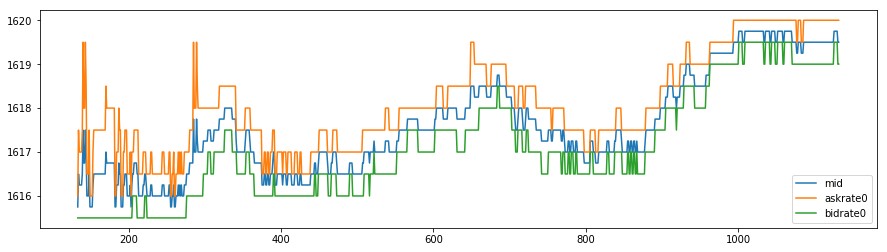

In [5]:
plt.figure(figsize=(15,4))
plt.plot(data['mid'][:1000])
plt.plot(data['askrate0'][:1000])
plt.plot(data['bidrate0'][:1000])
plt.legend()
plt.show()
#varying mean->non-stationary.Still, perform ADF and KPSS tests on stationarity

#### Run test on stationarity and autocorreleation (data exploration)

In [27]:
#test for autocorrelation (Ljung-Box test of autocorrelation in residuals)
statsmodels.stats.diagnostic.acorr_ljungbox(data['mid'])[1]#p-values
#there is autocorrelation present

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

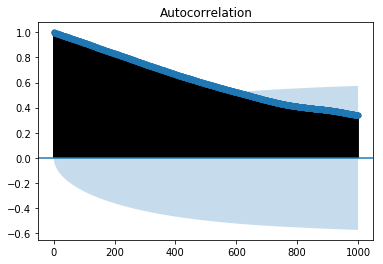

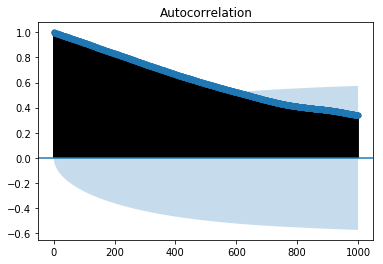

In [28]:
plot_acf(data['mid']-data['mid'].shift(10).mean(),lags=1000)#вычесть изменение мидпрайса или средний мидпрайс<-изменения маленькие
#slow decrease, does not converge quickly to zero, a sign of non-stationarity

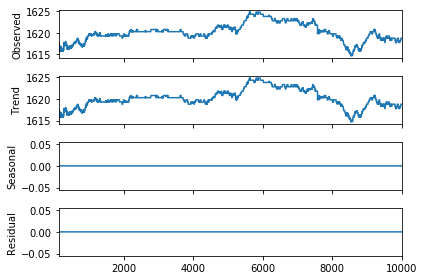

<Figure size 72x72 with 0 Axes>

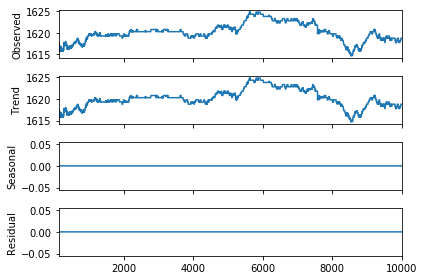

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(data[['mid']],freq=1)
plt.figure(figsize=(1,1))
decompose.plot() #no seasonality or patterns

In [33]:
adfuller(data['mid'],maxlag=7)[1]
#p-value is 29.5%, so we detect stationarity, H0=non-stationary

0.2950184394548214

In [34]:
#KPSS test
kpss(data['mid'])[1]
#p-value<1%. So, this test tells that there is  non-stationarity (Ho:staionary). tests are used for different kind of stationarity, so
#there is linear/differene stationarity

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

In [35]:
delt=data['mid']#delta prices
delt=delt.diff(periods=1)
delt.iloc[0]=0
delt=np.array(delt)
kpss(delt)[1] #differencing removes non-stationarity as p-value =10%

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


0.1

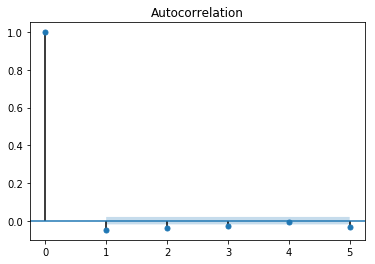

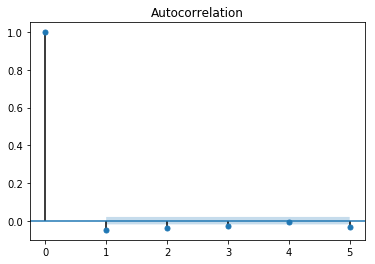

In [36]:
plot_acf(delt,lags=5)# instant decrease to zero -> stationarity after 1st order differencing

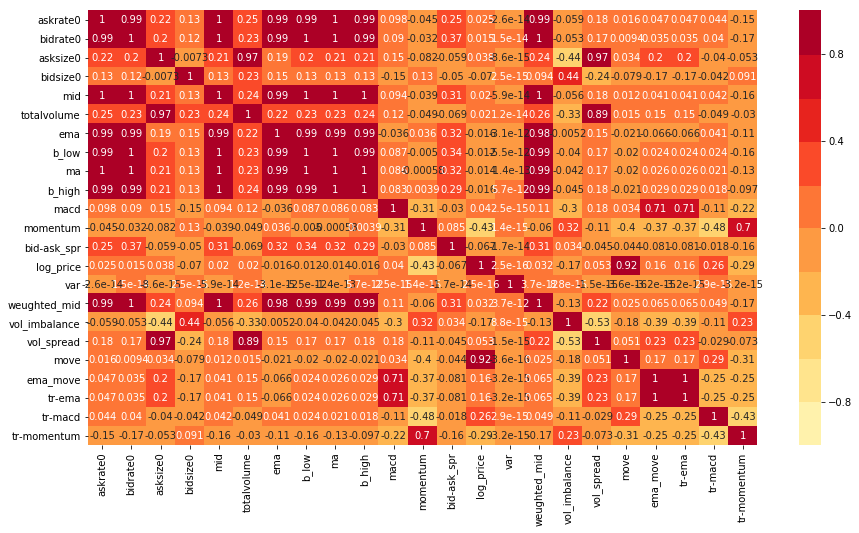

In [37]:
plt.figure(figsize=(15,8))#correlation between variables. I plan to remove highly correlated ones and find more that have higher 
#correlation with response variable, which is not yet finally defined
cor=data.corr()
sns.heatmap(cor,vmin=-1,vmax=1,center=0,cmap=sns.color_palette("YlOrRd",10),annot=True)

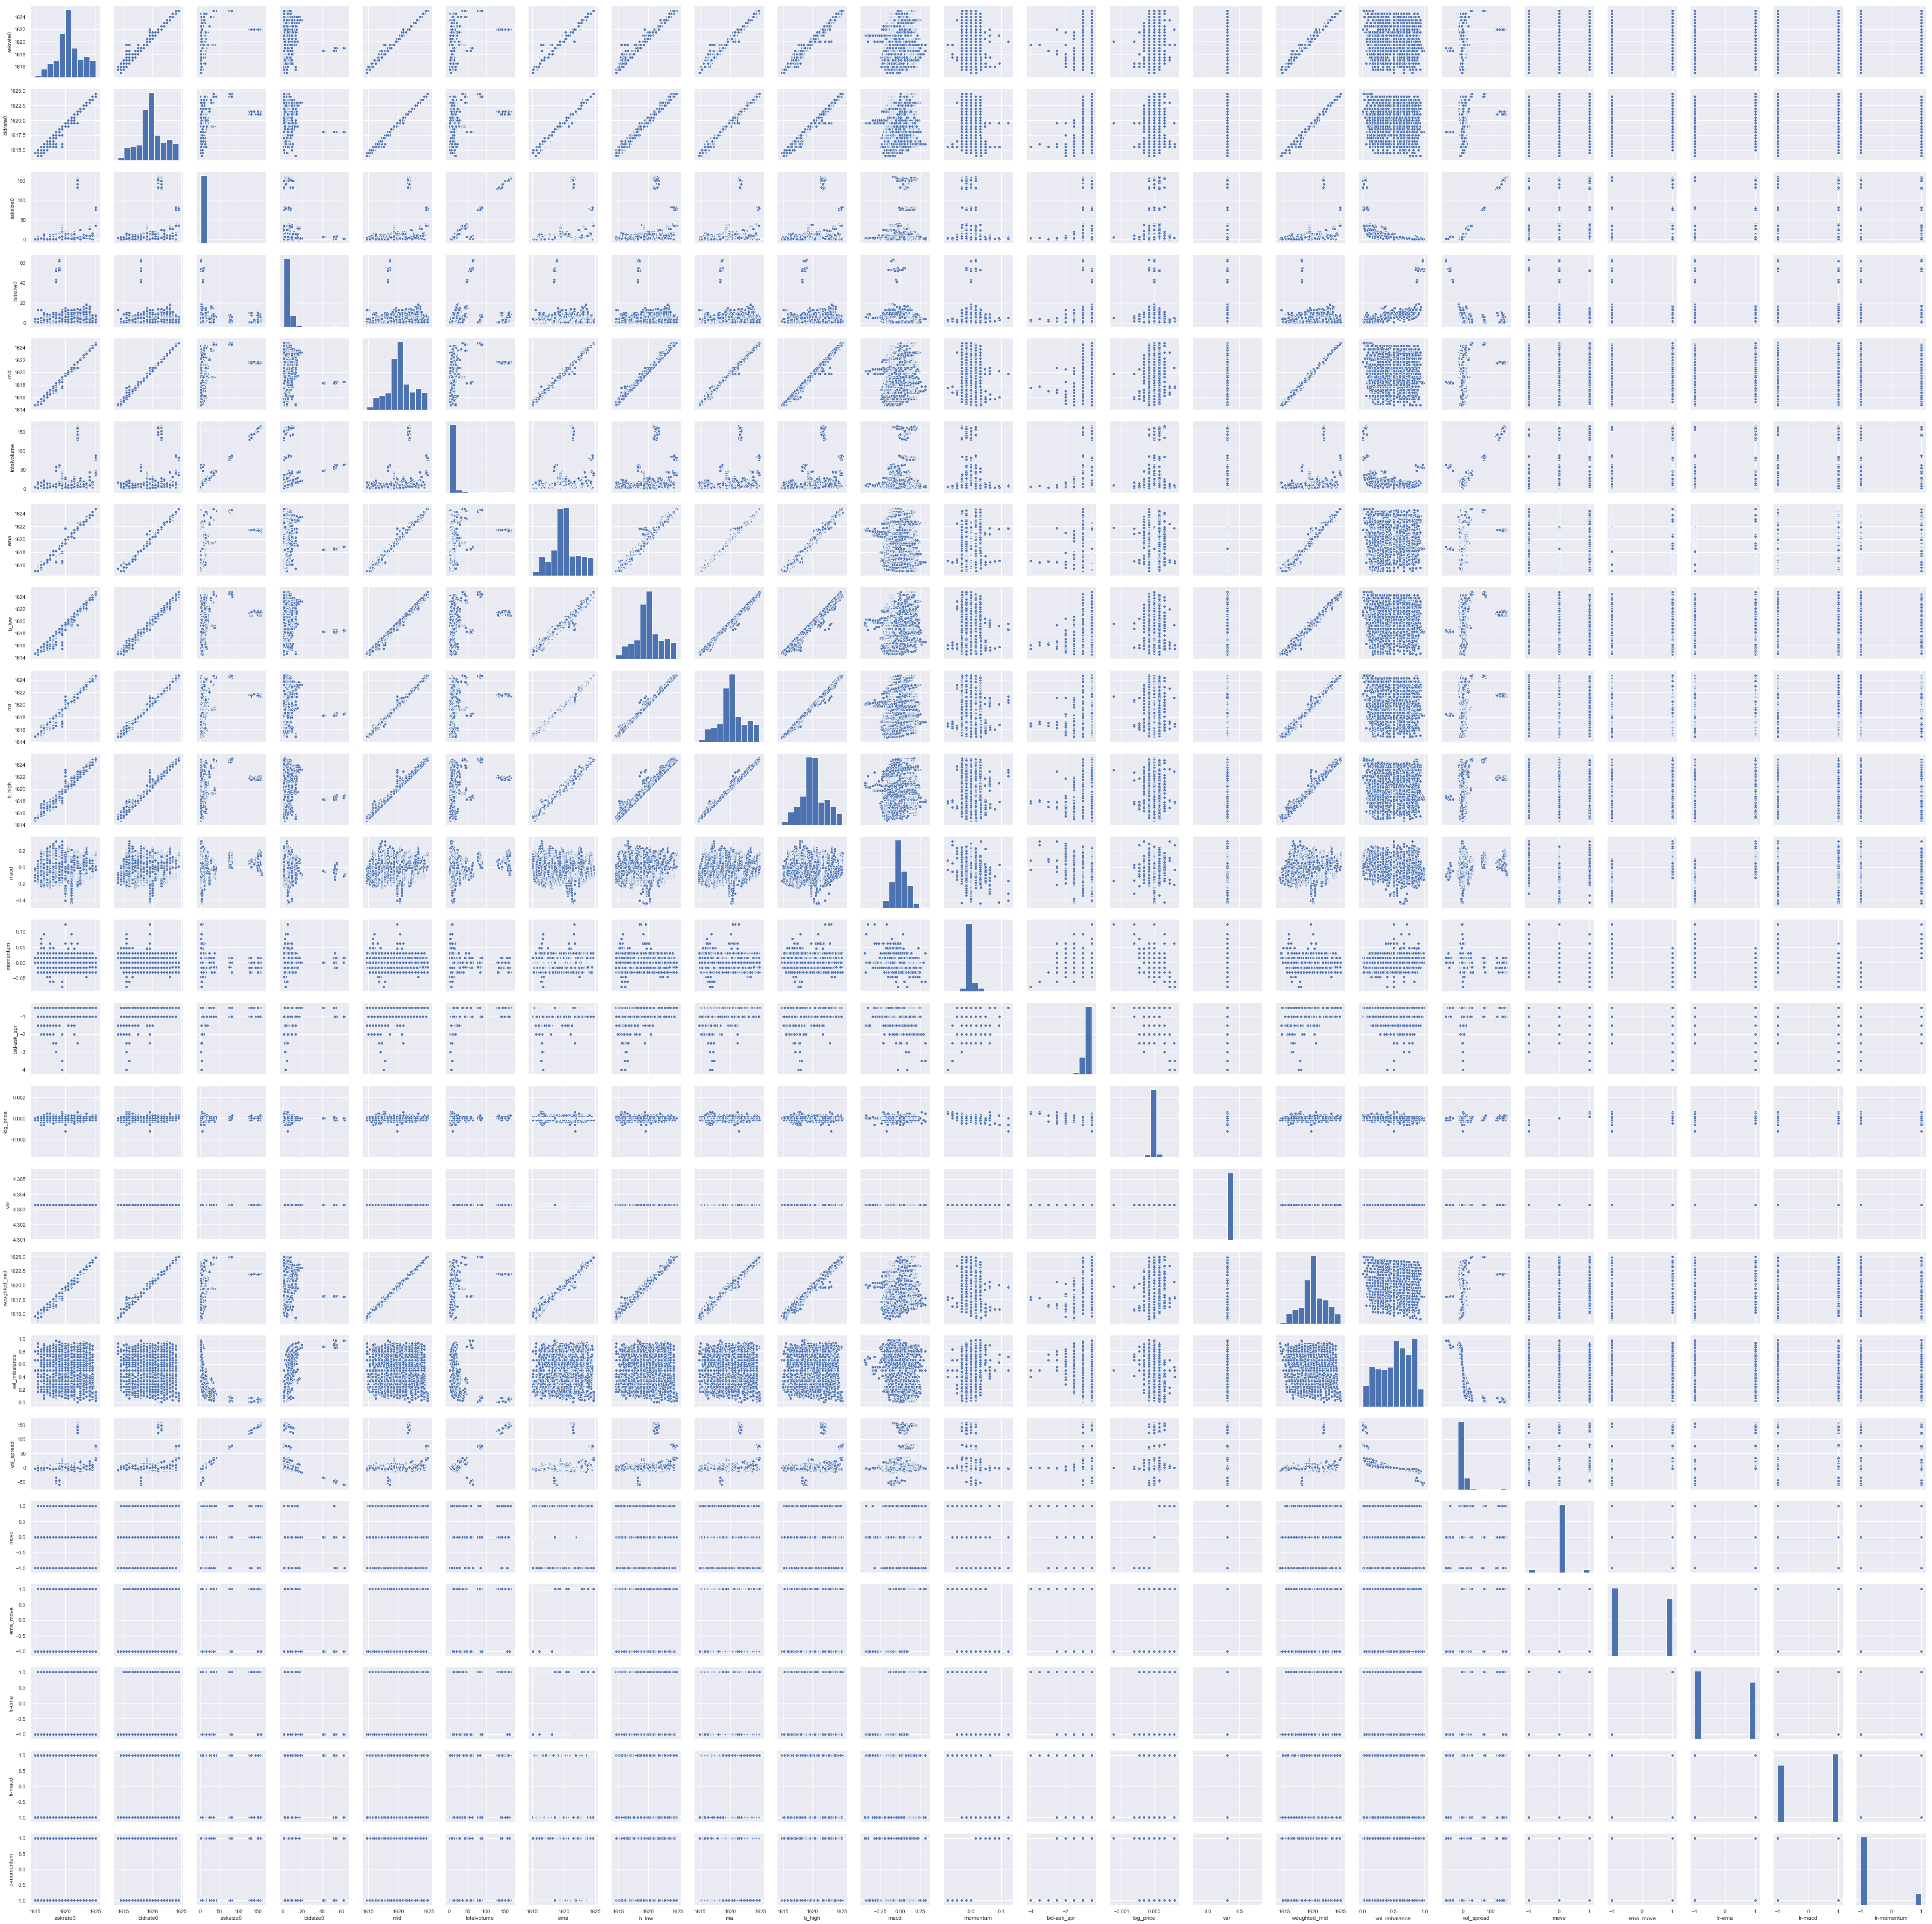

In [38]:
#sns.set(color_codes=True)    #pairwise histograms-works really slow
#n=list(data.columns)
#sns.pairplot(data,vars=n,palette="YlOrRd")
#plt.show()

#### Data

In [34]:
#generate train,test & cross validation sets
nrows=data.shape[0]
idxtrain=round(nrows*0.7) #70% for training set 
idxcv=nrows-idxtrain
print('training set size {}, cross-val set size {}'.format(idxtrain,idxcv))
idxcv=idxtrain+idxcv
train=data.iloc[:idxtrain,:]
cv=data.iloc[idxtrain:,:]#test set. I will introduce procedure for cross-validation later - k-fold cross validation

training set size 6907, cross-val set size 2960


#### Sub-model 1 - 1(up), 0(no change), -1(down) encoding for price movements (short-term trend)

In [40]:
train_set=prepare_sample(train,'move',10)#dependent variable-midprice direction
xtrain,ytrain=train_set[0],train_set[1]#train set
test_set=prepare_sample(cv,'move',10)
xcv,ycv=test_set[0],test_set[1]#test set

In [42]:
#SVM
svm=SVC(gamma='auto',C=10,kernel='linear'); #just my choice for now, haven`t done optimisation as it is costly, but I will minimize
#cost function once we find on what we predict 

In [43]:
feature_sel(RandomForestClassifier,xtrain,ytrain,xcv,ycv)#feature selection-

In [44]:
svm.fit(xtrain,ytrain)
pred=svm.predict(xcv)
pred=np.cumsum(pred) #cumulative sum of predictions to see total trend
min_pred=-pred.min()
pred+=min_pred #to eliminate negative values
ycv=np.cumsum(ycv)
ycv=ycv-ycv.min()

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Balanced accuracy is 0.6962640281249944


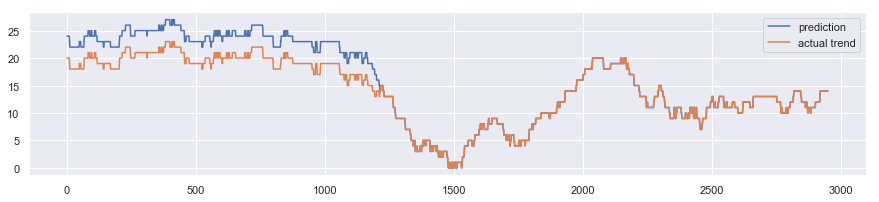

In [46]:
plt.figure(figsize=(15,3))
plt.plot(pred,label='prediction')
plt.plot(ycv,label='actual trend')
plt.legend();
print('Balanced accuracy is', balanced_accuracy_score(ycv,pred)); #balanced accuracy to account for different proportions of 1,-1,0

### Sub-model 2 - Exponential Moving Average (EMA)

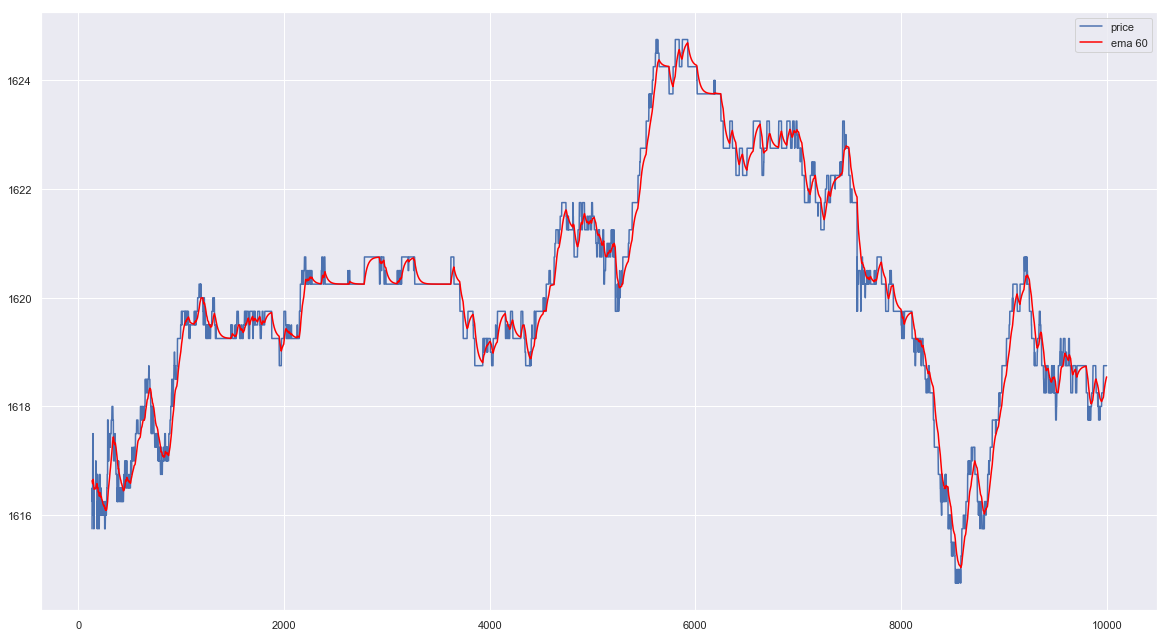

In [47]:
plt.figure(figsize=(20,11))
plt.plot(data['mid'],label='price')
plt.plot(data['ema'],label='ema 60',c='red')#chosen by looking at plots with different window sizes as it best approximates trend
plt.legend();

#### Option 1: EMA movement prediction by slope change

In [35]:
train_set1=prepare_sample(train,'ema_move',10)
xtrain1,ytrain1=train_set1[0],train_set1[1]
test_set1=prepare_sample(cv,'ema_move',10)
xcv1,ycv1=test_set1[0],test_set1[1]

In [36]:
svm1=SVC(gamma='auto',C=1.0,kernel='rbf')#same-no cost function minimization
svm1.fit(xtrain1,ytrain1);

In [37]:
feature_sel(RandomForestClassifier,xtrain1,ytrain1,xcv1,ycv1)

In [38]:
svm1.fit(xtrain1,ytrain1)
pred1=svm1.predict(xcv1)
pred1=np.cumsum(pred1)
min_pred=-pred1.min()
pred1+=min_pred #to eliminate negative values
ycv1=np.cumsum(ycv1)
ycv1=ycv1-ycv1.min()

Balanced accuracy is 0.0
Balanced accuracy is 14226.223050847457


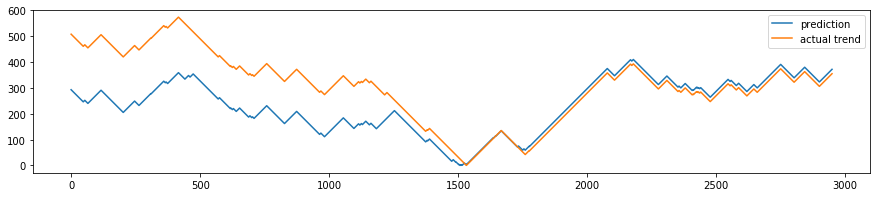

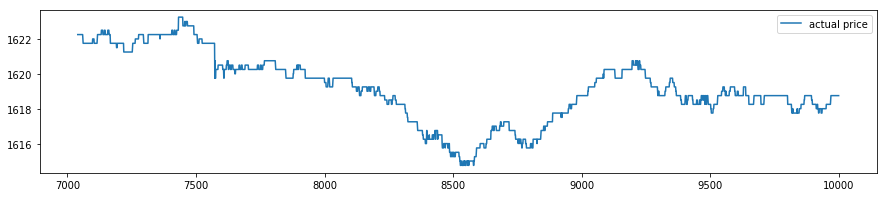

In [41]:
plt.figure(figsize=(15,3))
plt.plot(pred1,label='prediction')
plt.plot(ycv1,label='actual trend')
plt.legend()
plt.figure(figsize=(15,3))
plt.plot(data.iloc[idxtrain:idxcv,4],label='actual price')
plt.legend();
print('Balanced accuracy is', balanced_accuracy_score(ycv1,pred1))
print('Balanced accuracy is', mean_squared_error(ycv1,pred1))

#### Option 2: SVR for EMA prediction

In [9]:
train_set1=prepare_sample(train,'ema',10)
xtrain2,ytrain2=train_set1[0],train_set1[1]
test_set1=prepare_sample(cv,'ema',10)
xcv2,ycv2=test_set1[0],test_set1[1]

In [10]:
svr=SVR(kernel='linear',C=20.0, epsilon=1,gamma='scale')
svr.fit(xtrain2,ytrain2);

In [11]:
feature_sel(RandomForestRegressor,xtrain2,ytrain2,xcv2,ycv2)

MSE is 0.20271294405684337


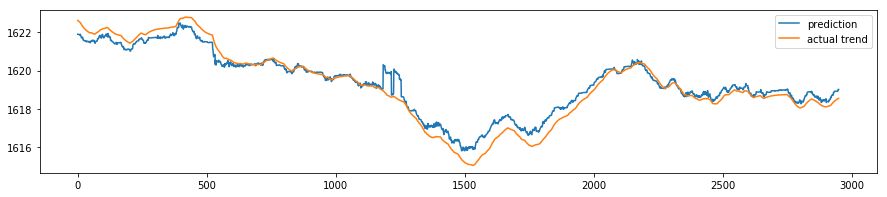

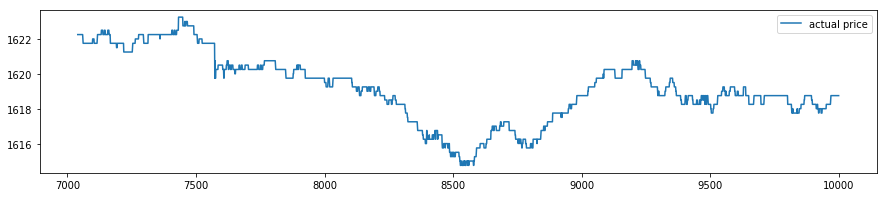

In [12]:
#training set
pred2=svr.predict(xcv2)
plt.figure(figsize=(15,3))
plt.plot(pred2,label='prediction')
plt.plot(ycv2,label='actual trend')
plt.legend()
plt.figure(figsize=(15,3))
plt.plot(data.iloc[idxtrain:idxcv,4],label='actual price')
plt.legend()
print('MSE is', mean_squared_error(ycv2,pred2));

In [ ]:
#the end. The following sells are just some ideas for future use

In [ ]:
#scopt
from skopt import gbrt_minimize
from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
space = [Real(0, 50, name='C'),
         Real(0, 8, name='epsilon'),
         Categorical(name="kernel", categories=["linear","poly"])
        ]
model=SVR(gamma='scale')

@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return np.mean(cross_val_score(model, X1, Y1, cv=TimeSeriesSplit(n_splits = 3), n_jobs=-1,
                                    scoring='neg_mean_squared_error'))         
res =  gbrt_minimize(objective, space, n_calls=50)
res

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    c = trial.suggest_int('C',1,2000)
    k=trial.suggest_categorical('kernel',['linear','poly'])
    ep=trial.suggest_uniform('epsilon',0,7)
    sv = SVR(kernel=k,C=c,epsilon=ep,gamma='scale')
    return np.mean(cross_val_score(sv, X1, Y1, cv=TimeSeriesSplit(n_splits = 3), n_jobs=-1,scoring='neg_mean_squared_error'))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
#hyperopt
from hyperopt import hp
space={'C': hp.choice('C',range( 0, 1000,1)),
    'kernel': hp.choice('kernel', [
        {'ktype': 'linear'},
        {'ktype': 'poly'}]),'epsilon':hp.uniform('epsilon',range(0,7))}


trials = Trials()
_ = fmin(objective, SPACE, trials=trials, algo=tpe.suggest, **HPO_PARAMS)




In [ ]:
plt.figure(figsize=(15,3))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('midprice', color=color)
ax1.plot(data.iloc[idxtrain:idxcv,4], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('trend', color=color)  # we already handled the x-label with ax1
ax2.plot(pred, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
plt.figure(figsize=(15,3))
#plt.ylim(1616.74,1616.76)
plt.plot(pr, label='predicted price')
plt.plot(for_plot,label='real price')
plt.legend()

In [ ]:
#SVR
from sklearn.svm import SVC

X1,Y1=prepare_sample(data,10)
tss = TimeSeriesSplit(n_splits = 2)
MSE=list()
MAE=list()
MSLE=list()
for train_index, test_index in tss.split(X1):
    print(train_index,'~~~',test_index)
    xtrainmid, xtestmid = X1[train_index], X1[test_index]
    ytrainmid, ytestmid = Y1[train_index], Y1[test_index]
    xtrainmid=np.array(xtrainmid)
    xtrainmid=xtrainmid.reshape(xtrainmid.shape[0],xtrainmid.shape[1])
    ytrainmid=np.array(ytrainmid).reshape(ytrainmid.shape[0],)
    xtestmid=np.array(xtestmid).reshape(xtestmid.shape[0],xtestmid.shape[1])
    ytestmid=np.array(ytestmid).reshape(ytestmid.shape[0],)
    Svr=SVC(gamma='auto')
    #Svr=SVR(kernel='rbf',C=10.0, epsilon=1,gamma='scale')
    Svr.fit(xtrainmid, ytrainmid)
    pred=Svr.predict(xtestmid)
    metrics=accuracy_metrics(ytestmid,pred) 
    MSE.append(metrics[0])
    #MAE.append(metrics[1])
   # MSLE.append(metrics[2])
    
MSE=np.array(MSE).mean()
#MAE=np.array(MAE).mean()
#MSLE=np.array(MSLE).mean()
print('MSE is {},'.format(MSE))

In [ ]:
#SVR
from sklearn.svm import SVC
SVC(gamma='auto')
X1,Y1=prepare_sample(data,1)
tss = TimeSeriesSplit(n_splits = 2)
MSE=list()
MAE=list()
MSLE=list()
for train_index, test_index in tss.split(X1):
    
    xtrainmid, xtestmid = X1[train_index], X1[test_index]
    ytrainmid, ytestmid = Y1[train_index], Y1[test_index]
    xtrainmid=np.array(xtrainmid)
    xtrainmid=xtrainmid.reshape(xtrainmid.shape[0],xtrainmid.shape[1])
    ytrainmid=np.array(ytrainmid).reshape(ytrainmid.shape[0],)
    xtestmid=np.array(xtestmid).reshape(xtestmid.shape[0],xtestmid.shape[1])
    ytestmid=np.array(ytestmid).reshape(ytestmid.shape[0],)
    Svr=SVC(gamma='auto')
    #Svr=SVR(kernel='rbf',C=10.0, epsilon=1,gamma='scale')
    Svr.fit(xtrainmid, ytrainmid)
    metrics=accuracy_metrics(ytestmid,Svr.predict(xtestmid)) 
    MSE.append(metrics[0])
    MAE.append(metrics[1])
   # MSLE.append(metrics[2])
    
MSE=np.array(MSE).mean()
MAE=np.array(MAE).mean()
#MSLE=np.array(MSLE).mean()
print('MSE is {}, MAE is {}'.format(MSE,MAE))

In [ ]:
#rolling window predictions
files=['AMZN_1','AMZN_2']
test_mse=list()
total_predictions=list()
total_true_val=list()
#read files,append names
i=0
while i <len(files):
    f=files[i]
    f=pd.read_csv(f+'.csv')
    f=clean_data(f)
    test_data=calculate_indicators(f,20,20,20,20,30)
    test_data=prepare_sample(test_data)
    pred=Svr.predict(test_data[0])
    test_mse.append(mean_squared_error(test_data[1],pred))
    total_predictions.extend(list(pred))
    total_true_val.extend(list(test_data[1]))
    Svr.fit(test_data[0],pred)
    i+=1
    
print(np.array(test_mse).mean())

In [ ]:
`